# Quantum Neural Network for User Behavioral Profiling

This notebook implements a **Quantum Neural Network (QNN)** for user behavioral profiling using a **LANL authentication dataset**. The code processes raw data, extracts features, clusters users, and trains a QNN to classify user behaviors. Below is a detailed breakdown of each section.

## 1. Imports and Setup


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, roc_auc_score, precision_recall_curve
)
import torch
import torch.nn as nn
import torch.nn.functional as F
import logging
import sys
import gc
import time

### Purpose:
Import necessary libraries for data processing, machine learning, visualization, and quantum neural network implementation.

### Key Libraries:
- **pandas**, **numpy**: Data manipulation and numerical operations.  
- **sklearn**: Preprocessing, clustering, dimensionality reduction, and evaluation metrics.  
- **torch**: PyTorch for building and training the QNN.  
- **logging**, **gc**, **time**: Logging, memory management, and timing.

### Logging Configuration


In [ ]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
console = logging.StreamHandler(sys.stdout)
console.setLevel(logging.INFO)
logging.getLogger().addHandler(console)

**Purpose:**  
Set up logging to track progress and debug issues, outputting messages to the console with timestamps.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")
if torch.cuda.is_available():
    logging.info(f"GPU name: {torch.cuda.get_device_name(0)}")
torch.cuda.empty_cache() if torch.cuda.is_available() else None


### Device Configuration

**Purpose:**  
Configure the computation device (GPU if available, else CPU) and clear GPU memory to optimize performance.

**Key Parameters:**
- `device`: Determines whether computations use CUDA (GPU) or CPU.  
- `torch.cuda.empty_cache()`: Frees unused GPU memory.

## 2. Quantum Neural Network Parameters

In [ ]:
n_qubits = 2
n_layers = 2
n_epochs = 150
batch_size = 1
hidden_dim = 8

### Hyperparameter Definition

**Purpose:**  
Define hyperparameters for the Quantum Neural Network (QNN).

**Key Parameters:**
- `n_qubits`: Number of qubits (**2**) for the quantum circuit.  
- `n_layers`: Number of layers (**2**) in the quantum circuit ansatz.  
- `n_epochs`: Training iterations (**150**).  
- `batch_size`: Samples per training batch (**1**, due to quantum circuit constraints).  
- `hidden_dim`: Hidden layer size (**8**) in the classical neural network component.

---

## 3. Quantum Circuit Components

### Quantum Gates


In [ ]:
def rx_gate(theta):
    cos = torch.cos(theta / 2).view(-1, 1, 1)
    sin = torch.sin(theta / 2).view(-1, 1, 1)
    gate = torch.zeros((theta.shape[0], 2, 2), dtype=torch.complex64, device=device)
    gate[:, 0, 0] = cos.squeeze()
    gate[:, 0, 1] = -1j * sin.squeeze()
    gate[:, 1, 0] = -1j * sin.squeeze()
    gate[:, 1, 1] = cos.squeeze()
    return gate

def ry_gate(theta):
    cos = torch.cos(theta / 2).view(-1, 1, 1)
    sin = torch.sin(theta / 2).view(-1, 1, 1)
    gate = torch.zeros((theta.shape[0], 2, 2), dtype=torch.complex64, device=device)
    gate[:, 0, 0] = cos.squeeze()
    gate[:, 0, 1] = -sin.squeeze()
    gate[:, 1, 0] = sin.squeeze()
    gate[:, 1, 1] = cos.squeeze()
    return gate

def rz_gate(theta):
    gate = torch.zeros((theta.shape[0], 2, 2), dtype=torch.complex64, device=device)
    gate[:, 0, 0] = torch.exp(-1j * theta / 2).view(-1)
    gate[:, 1, 1] = torch.exp(1j * theta / 2).view(-1)
    return gate

def cnot_gate(batch_size):
    gate = torch.tensor([[1, 0, 0, 0],
                        [0, 1, 0, 0],
                        [0, 0, 0, 1],
                        [0, 0, 1, 0]], dtype=torch.complex64, device=device)
    return gate.unsqueeze(0).expand(batch_size, 4, 4)

### Quantum Gates

**Purpose:**  
Define quantum gates (`RX`, `RY`, `RZ`, and `CNOT`) used in the quantum circuit.

**Key Details:**
- `rx_gate`, `ry_gate`, `rz_gate`: Single-qubit rotation gates parameterized by angle `theta`.  
- `cnot_gate`: Two-qubit controlled-NOT gate for entanglement.  
- Gates are implemented as batched operations using PyTorch tensors for compatibility with the QNN.

---

### Quantum Circuit


In [ ]:
def quantum_circuit(X, weights):
    X = torch.tensor(X, dtype=torch.float32, device=device)
    batch_size = X.shape[0]
    if batch_size == 0:
        raise ValueError("Empty input to quantum_circuit")
    
    states = torch.zeros(batch_size, 2**n_qubits, dtype=torch.complex64, device=device)
    states[:, 0] = 1
    
    # ZZFeatureMap encoding
    for i in range(n_qubits):
        angles = X[:, i % X.shape[1]] * np.pi
        rx = rx_gate(angles)
        ry = ry_gate(angles)
        states = torch.bmm(rx, states.view(batch_size, 2, -1)).view(batch_size, -1)
        states = torch.bmm(ry, states.view(batch_size, 2, -1)).view(batch_size, -1)
        if i < n_qubits-1:
            angles_ij = (np.pi - X[:, i % X.shape[1]]) * (np.pi - X[:, (i+1) % X.shape[1]])
            rz_i = rz_gate(angles_ij)
            states = torch.bmm(rz_i, states.view(batch_size, 2, -1)).view(batch_size, -1)
            states = torch.bmm(cnot_gate(batch_size), states.view(batch_size, 4, -1)).view(batch_size, -1)
    
    # RealAmplitudes ansatz
    for layer in range(n_layers):
        for i in range(n_qubits):
            rx = rx_gate(weights[layer, i, 0].repeat(batch_size))
            ry = ry_gate(weights[layer, i, 1].repeat(batch_size))
            rz = rz_gate(weights[layer, i, 2].repeat(batch_size))
            states = torch.bmm(rx, states.view(batch_size, 2, -1)).view(batch_size, -1)
            states = torch.bmm(ry, states.view(batch_size, 2, -1)).view(batch_size, -1)
            states = torch.bmm(rz, states.view(batch_size, 2, -1)).view(batch_size, -1)
        for i in range(n_qubits-1):
            states = torch.bmm(cnot_gate(batch_size), states.view(batch_size, 4, -1)).view(batch_size, -1)
    
    # Measure Pauli-Z
    obs = torch.diag(torch.tensor([1, -1], dtype=torch.complex64, device=device))
    features = []
    for i in range(n_qubits):
        full_obs = torch.kron(
            torch.eye(2**i, dtype=torch.complex64, device=device),
            torch.kron(obs, torch.eye(2**(n_qubits-i-1), dtype=torch.complex64, device=device))
        )
        expvals = torch.real(torch.einsum('bi,ij,bj->b', states.conj(), full_obs, states))
        features.append(expvals)
    return torch.stack(features, dim=1)

### Quantum Circuit

**Purpose:**  
Simulate a quantum circuit that encodes input features and applies a parameterized ansatz to generate quantum features.

**Key Components:**
- **ZZFeatureMap Encoding**: Encodes classical input data (`X`) into quantum states using `RX`, `RY`, `RZ` gates and `CNOT` for entanglement.  
- **RealAmplitudes Ansatz**: Applies parameterized `RX`, `RY`, `RZ` gates and `CNOT` gates in multiple layers to create a trainable quantum circuit.  
- **Measurement**: Measures the expectation values of Pauli-Z operators for each qubit, producing quantum features.

---

## 4. Quantum Neural Network (QNN) Model


In [ ]:
class QNN(nn.Module):
    def __init__(self, n_qubits, n_layers, n_classes, hidden_dim):
        super(QNN, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.weights = nn.Parameter(
            torch.tensor(np.random.uniform(0, np.pi, (n_layers, n_qubits, 3)),
                         dtype=torch.float32, device=device)
        )
        self.fc1 = nn.Linear(n_qubits, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, n_classes)
    
    def forward(self, X):
        quantum_features = quantum_circuit(X, self.weights)
        x = torch.tanh(quantum_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

### Quantum Neural Network (QNN) Model

**Purpose:**  
Define a hybrid quantum-classical neural network combining a quantum circuit with classical fully connected layers.

**Key Components:**
- **Quantum Layer**: Uses `quantum_circuit` to generate quantum features.  
- **Classical Layers**: Applies a hyperbolic tangent activation, a hidden layer with ReLU activation, and a final layer with softmax for classification.  
- **Parameters**: Quantum circuit weights are initialized randomly between 0 and π.

---

## 5. Training the QNN


In [ ]:
def train_qnn(X, y, n_classes, n_components=2):
    try:
        logging.info(f"Input shapes: X={X.shape}, y={y.shape}")
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X)
        logging.info(f"PCA output shape: {X_pca.shape}")
        
        model = QNN(n_qubits, n_layers, n_classes, hidden_dim).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        
        logging.info("Training QNN...")
        start_time = time.time()
        for epoch in range(n_epochs):
            model.train()
            optimizer.zero_grad()
            total_loss = 0
            for i in range(0, len(X_pca), batch_size):
                i_end = min(i + batch_size, len(X_pca))
                X_batch = X_pca[i:i_end]
                y_batch = y[i:i_end]
                
                probs = model(X_batch)
                y_one_hot = F.one_hot(torch.tensor(y_batch, dtype=torch.long, device=device), n_classes).float()
                
                loss = F.cross_entropy(probs, y_one_hot)
                loss.backward()
                total_loss += loss.item() * (i_end - i)
                
                del probs, y_one_hot, loss
                torch.cuda.empty_cache()
                gc.collect()
            
            optimizer.step()
            avg_loss = total_loss / len(X_pca)
            logging.info(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")
        
        logging.info(f"Training took {time.time() - start_time:.2f}s")
        return model, pca
    except Exception as e:
        logging.error(f"Error in QNN training: {e}")
        raise

### Training the QNN

**Purpose:**  
Train the QNN on preprocessed data with PCA for dimensionality reduction.

**Key Steps:**
- **PCA**: Reduces input features to `n_components` (default **2**) to match quantum circuit input requirements.  
- **Training Loop**: Iterates over `n_epochs`, computing cross-entropy loss for mini-batches, backpropagating, and updating model parameters using the Adam optimizer.  
- **Memory Management**: Clears unused tensors and GPU memory to handle small batch sizes.  
- **Output**: Returns the trained model and PCA transformer.

---

## 6. Evaluating the QNN


In [ ]:
def evaluate_qnn(X, y, model, pca, n_classes):
    try:
        X_pca = pca.transform(X)
        model.eval()
        with torch.no_grad():
            probs = model(X_pca)
            y_pred = torch.argmax(probs, dim=1).cpu().numpy()
        report = classification_report(y, y_pred, zero_division=0)
        logging.info(")
        return y_pred
    except Exception as e:
        logging.error(f"Error in evaluation: {e}")
        raise

### Evaluating the QNN

**Purpose:**  
Evaluate the trained QNN on a test set.

**Key Steps:**
- Applies PCA transformation to test data.  
- Computes predictions using the trained model in evaluation mode.  
- Generates a classification report with precision, recall, and F1-score.  
- Returns predicted labels.

---

## 7. Data Loading


In [ ]:
def load_data(filepath):
    try:
        df = pd.read_csv(filepath, nrows=500)
        logging.info(f"Raw data shape: {df.shape}")
        logging.info(f"Columns: {df.columns.tolist()}")
        df = df.fillna(df.mean(numeric_only=True))
        le_user = LabelEncoder()
        df['user'] = le_user.fit_transform(df['user'])
        return df, le_user
    except Exception as e:
        logging.error(f"Error loading data: {e}")
        raise

### Data Loading

**Purpose:**  
Load and preprocess the LANL authentication dataset.

**Key Steps:**
- Reads a CSV file (limited to 500 rows for efficiency).  
- Fills missing numeric values with column means.  
- Encodes the user column using `LabelEncoder`.  
- Returns the processed DataFrame and the label encoder.

---

## 8. Feature Engineering


In [ ]:
def create_behavioral_features(df):
    try:
        df = df.copy()
        categorical_cols = [col for col in df.columns if col != 'user' and df[col].dtype == 'object']
        logging.info(f"Categorical columns: {categorical_cols}")
        for col in categorical_cols:
            df[col] = LabelEncoder().fit_transform(df[col].astype(str))
        
        numeric_cols = [col for col in df.columns if col != 'user']
        X = df[numeric_cols].values
        
        X = np.clip(X, np.percentile(X, 5, axis=0), np.percentile(X, 95, axis=0))
        
        n_features = min(3, len(numeric_cols))
        X = X[:, :n_features]
        
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        y = df['user'].values
        logging.info(f"Selected features: {numeric_cols[:n_features]}")
        return X, y, numeric_cols[:n_features]
    except Exception as e:
        logging.error(f"Error in feature creation: {e}")
        raise

#### Feature Engineering

**Purpose:**  
Transform raw data into features suitable for the QNN.

**Key Steps:**
- Encodes categorical columns using `LabelEncoder`.  
- Selects numeric columns and clips outliers (5th to 95th percentiles).  
- Limits features to a maximum of **3** for computational efficiency.  
- Scales features to [0, 1] using `MinMaxScaler`.  
- Returns feature matrix `X`, labels `y`, and selected column names.

---

## 9. User Clustering


In [ ]:
def cluster_users(X, y, n_clusters=3):
    try:
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(X_scaled)
        logging.info(f"Using {n_clusters} clusters")
        return cluster_labels
    except Exception as e:
        logging.error(f"Error in clustering: {e}")
        raise

### User Clustering

**Purpose:**  
Group users into clusters based on behavioral features.

**Key Steps:**
- Scales features using `MinMaxScaler`.  
- Applies K-means clustering with `n_clusters` (**default 3**).  
- Returns cluster labels to replace original user labels.

---

## 10. Main Execution


In [1]:
if __name__ == "__main__":
    filepath = r"C:\Users\USER\QML-UEBA\Behavioural_profiling\Data\raw\lanl-auth-dataset-sampled.csv"
    
    try:
        df, le_user = load_data(filepath)
        X, y, selected_cols = create_behavioral_features(df)
        del df
        gc.collect()
        
        n_clusters = 3
        logging.info(f"Clustering into {n_clusters} user groups...")
        y = cluster_users(X, y, n_clusters)
        
        max_samples = 150
        logging.info(f"Using {max_samples} samples")
        idx = np.random.choice(len(X), max_samples, replace=False)
        X, y = X[idx], y[idx]
        del idx
        gc.collect()
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        logging.info(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
        del X, y
        gc.collect()
        
        model, pca = train_qnn(X_train, y_train, n_classes=len(np.unique(y_train)))
        
        logging.info("Evaluating on test set...")
        y_pred = evaluate_qnn(X_test, y_test, model, pca, n_classes=len(np.unique(y_train)))
        
    except Exception as e:
        logging.error(f"Main execution error: {e}")
        raise

2025-04-13 19:09:06,636 - Using device: cuda


Using device: cuda


2025-04-13 19:09:06,640 - GPU name: NVIDIA T500


GPU name: NVIDIA T500


2025-04-13 19:09:06,661 - Raw data shape: (500, 3)


Raw data shape: (500, 3)


2025-04-13 19:09:06,664 - Columns: ['time', 'user', 'computer']


Columns: ['time', 'user', 'computer']


2025-04-13 19:09:06,668 - Categorical columns: ['computer']


Categorical columns: ['computer']


2025-04-13 19:09:06,673 - Selected features: ['time', 'computer']


Selected features: ['time', 'computer']


2025-04-13 19:09:06,752 - Clustering into 3 user groups...


Clustering into 3 user groups...


2025-04-13 19:09:06,941 - Using 3 clusters


Using 3 clusters


2025-04-13 19:09:06,945 - Using 150 samples


Using 150 samples


2025-04-13 19:09:07,041 - Train shape: (120, 2), Test shape: (30, 2)


Train shape: (120, 2), Test shape: (30, 2)


2025-04-13 19:09:07,142 - Input shapes: X=(120, 2), y=(120,)


Input shapes: X=(120, 2), y=(120,)


2025-04-13 19:09:07,144 - PCA output shape: (120, 2)


PCA output shape: (120, 2)


2025-04-13 19:09:09,060 - Training QNN...


Training QNN...


2025-04-13 19:09:25,552 - Epoch 1/150, Loss: 1.0954


Epoch 1/150, Loss: 1.0954


2025-04-13 19:09:41,606 - Epoch 2/150, Loss: 1.0940


Epoch 2/150, Loss: 1.0940


2025-04-13 19:09:57,692 - Epoch 3/150, Loss: 1.0925


Epoch 3/150, Loss: 1.0925


2025-04-13 19:10:13,996 - Epoch 4/150, Loss: 1.0910


Epoch 4/150, Loss: 1.0910


2025-04-13 19:10:30,294 - Epoch 5/150, Loss: 1.0894


Epoch 5/150, Loss: 1.0894


2025-04-13 19:10:46,274 - Epoch 6/150, Loss: 1.0878


Epoch 6/150, Loss: 1.0878


2025-04-13 19:11:02,648 - Epoch 7/150, Loss: 1.0862


Epoch 7/150, Loss: 1.0862


2025-04-13 19:11:19,170 - Epoch 8/150, Loss: 1.0846


Epoch 8/150, Loss: 1.0846


2025-04-13 19:11:35,549 - Epoch 9/150, Loss: 1.0829


Epoch 9/150, Loss: 1.0829


2025-04-13 19:11:51,515 - Epoch 10/150, Loss: 1.0812


Epoch 10/150, Loss: 1.0812


2025-04-13 19:12:07,806 - Epoch 11/150, Loss: 1.0795


Epoch 11/150, Loss: 1.0795


2025-04-13 19:12:24,283 - Epoch 12/150, Loss: 1.0778


Epoch 12/150, Loss: 1.0778


2025-04-13 19:12:40,854 - Epoch 13/150, Loss: 1.0760


Epoch 13/150, Loss: 1.0760


2025-04-13 19:12:57,631 - Epoch 14/150, Loss: 1.0743


Epoch 14/150, Loss: 1.0743


2025-04-13 19:13:14,012 - Epoch 15/150, Loss: 1.0726


Epoch 15/150, Loss: 1.0726


2025-04-13 19:13:30,089 - Epoch 16/150, Loss: 1.0709


Epoch 16/150, Loss: 1.0709


2025-04-13 19:13:45,858 - Epoch 17/150, Loss: 1.0692


Epoch 17/150, Loss: 1.0692


2025-04-13 19:14:01,885 - Epoch 18/150, Loss: 1.0675


Epoch 18/150, Loss: 1.0675


2025-04-13 19:14:17,880 - Epoch 19/150, Loss: 1.0657


Epoch 19/150, Loss: 1.0657


2025-04-13 19:14:33,640 - Epoch 20/150, Loss: 1.0640


Epoch 20/150, Loss: 1.0640


2025-04-13 19:14:49,959 - Epoch 21/150, Loss: 1.0623


Epoch 21/150, Loss: 1.0623


2025-04-13 19:15:06,257 - Epoch 22/150, Loss: 1.0606


Epoch 22/150, Loss: 1.0606


2025-04-13 19:15:21,911 - Epoch 23/150, Loss: 1.0589


Epoch 23/150, Loss: 1.0589


2025-04-13 19:15:38,065 - Epoch 24/150, Loss: 1.0572


Epoch 24/150, Loss: 1.0572


2025-04-13 19:15:54,027 - Epoch 25/150, Loss: 1.0554


Epoch 25/150, Loss: 1.0554


2025-04-13 19:16:09,990 - Epoch 26/150, Loss: 1.0537


Epoch 26/150, Loss: 1.0537


2025-04-13 19:16:25,733 - Epoch 27/150, Loss: 1.0519


Epoch 27/150, Loss: 1.0519


2025-04-13 19:16:40,826 - Epoch 28/150, Loss: 1.0501


Epoch 28/150, Loss: 1.0501


2025-04-13 19:16:56,172 - Epoch 29/150, Loss: 1.0482


Epoch 29/150, Loss: 1.0482


2025-04-13 19:17:11,852 - Epoch 30/150, Loss: 1.0463


Epoch 30/150, Loss: 1.0463


2025-04-13 19:17:27,407 - Epoch 31/150, Loss: 1.0444


Epoch 31/150, Loss: 1.0444


2025-04-13 19:17:42,871 - Epoch 32/150, Loss: 1.0424


Epoch 32/150, Loss: 1.0424


2025-04-13 19:17:58,656 - Epoch 33/150, Loss: 1.0404


Epoch 33/150, Loss: 1.0404


2025-04-13 19:18:14,728 - Epoch 34/150, Loss: 1.0385


Epoch 34/150, Loss: 1.0385


2025-04-13 19:18:30,719 - Epoch 35/150, Loss: 1.0365


Epoch 35/150, Loss: 1.0365


2025-04-13 19:18:46,015 - Epoch 36/150, Loss: 1.0345


Epoch 36/150, Loss: 1.0345


2025-04-13 19:19:01,266 - Epoch 37/150, Loss: 1.0324


Epoch 37/150, Loss: 1.0324


2025-04-13 19:19:16,600 - Epoch 38/150, Loss: 1.0303


Epoch 38/150, Loss: 1.0303


2025-04-13 19:19:31,964 - Epoch 39/150, Loss: 1.0281


Epoch 39/150, Loss: 1.0281


2025-04-13 19:19:48,562 - Epoch 40/150, Loss: 1.0259


Epoch 40/150, Loss: 1.0259


2025-04-13 19:20:04,758 - Epoch 41/150, Loss: 1.0237


Epoch 41/150, Loss: 1.0237


2025-04-13 19:20:20,370 - Epoch 42/150, Loss: 1.0215


Epoch 42/150, Loss: 1.0215


2025-04-13 19:20:36,032 - Epoch 43/150, Loss: 1.0193


Epoch 43/150, Loss: 1.0193


2025-04-13 19:20:51,483 - Epoch 44/150, Loss: 1.0172


Epoch 44/150, Loss: 1.0172


2025-04-13 19:21:06,796 - Epoch 45/150, Loss: 1.0151


Epoch 45/150, Loss: 1.0151


2025-04-13 19:21:22,559 - Epoch 46/150, Loss: 1.0129


Epoch 46/150, Loss: 1.0129


2025-04-13 19:21:37,944 - Epoch 47/150, Loss: 1.0108


Epoch 47/150, Loss: 1.0108


2025-04-13 19:21:53,438 - Epoch 48/150, Loss: 1.0082


Epoch 48/150, Loss: 1.0082


2025-04-13 19:22:08,845 - Epoch 49/150, Loss: 1.0054


Epoch 49/150, Loss: 1.0054


2025-04-13 19:22:24,039 - Epoch 50/150, Loss: 1.0025


Epoch 50/150, Loss: 1.0025


2025-04-13 19:22:39,621 - Epoch 51/150, Loss: 0.9998


Epoch 51/150, Loss: 0.9998


2025-04-13 19:22:55,285 - Epoch 52/150, Loss: 0.9971


Epoch 52/150, Loss: 0.9971


2025-04-13 19:23:10,572 - Epoch 53/150, Loss: 0.9944


Epoch 53/150, Loss: 0.9944


2025-04-13 19:23:26,519 - Epoch 54/150, Loss: 0.9919


Epoch 54/150, Loss: 0.9919


2025-04-13 19:23:42,861 - Epoch 55/150, Loss: 0.9894


Epoch 55/150, Loss: 0.9894


2025-04-13 19:23:58,344 - Epoch 56/150, Loss: 0.9871


Epoch 56/150, Loss: 0.9871


2025-04-13 19:24:14,072 - Epoch 57/150, Loss: 0.9850


Epoch 57/150, Loss: 0.9850


2025-04-13 19:24:29,746 - Epoch 58/150, Loss: 0.9828


Epoch 58/150, Loss: 0.9828


2025-04-13 19:24:45,219 - Epoch 59/150, Loss: 0.9807


Epoch 59/150, Loss: 0.9807


2025-04-13 19:25:00,518 - Epoch 60/150, Loss: 0.9784


Epoch 60/150, Loss: 0.9784


2025-04-13 19:25:16,255 - Epoch 61/150, Loss: 0.9762


Epoch 61/150, Loss: 0.9762


2025-04-13 19:25:32,025 - Epoch 62/150, Loss: 0.9740


Epoch 62/150, Loss: 0.9740


2025-04-13 19:25:47,477 - Epoch 63/150, Loss: 0.9717


Epoch 63/150, Loss: 0.9717


2025-04-13 19:26:03,335 - Epoch 64/150, Loss: 0.9697


Epoch 64/150, Loss: 0.9697


2025-04-13 19:26:19,067 - Epoch 65/150, Loss: 0.9678


Epoch 65/150, Loss: 0.9678


2025-04-13 19:26:34,612 - Epoch 66/150, Loss: 0.9657


Epoch 66/150, Loss: 0.9657


2025-04-13 19:26:50,153 - Epoch 67/150, Loss: 0.9636


Epoch 67/150, Loss: 0.9636


2025-04-13 19:27:06,766 - Epoch 68/150, Loss: 0.9615


Epoch 68/150, Loss: 0.9615


2025-04-13 19:27:22,501 - Epoch 69/150, Loss: 0.9596


Epoch 69/150, Loss: 0.9596


2025-04-13 19:27:38,107 - Epoch 70/150, Loss: 0.9578


Epoch 70/150, Loss: 0.9578


2025-04-13 19:27:53,538 - Epoch 71/150, Loss: 0.9560


Epoch 71/150, Loss: 0.9560


2025-04-13 19:28:09,438 - Epoch 72/150, Loss: 0.9543


Epoch 72/150, Loss: 0.9543


2025-04-13 19:28:24,665 - Epoch 73/150, Loss: 0.9526


Epoch 73/150, Loss: 0.9526


2025-04-13 19:28:40,242 - Epoch 74/150, Loss: 0.9509


Epoch 74/150, Loss: 0.9509


2025-04-13 19:28:56,940 - Epoch 75/150, Loss: 0.9491


Epoch 75/150, Loss: 0.9491


2025-04-13 19:29:13,076 - Epoch 76/150, Loss: 0.9474


Epoch 76/150, Loss: 0.9474


2025-04-13 19:29:28,251 - Epoch 77/150, Loss: 0.9458


Epoch 77/150, Loss: 0.9458


2025-04-13 19:29:43,225 - Epoch 78/150, Loss: 0.9443


Epoch 78/150, Loss: 0.9443


2025-04-13 19:29:59,832 - Epoch 79/150, Loss: 0.9427


Epoch 79/150, Loss: 0.9427


2025-04-13 19:30:14,394 - Epoch 80/150, Loss: 0.9412


Epoch 80/150, Loss: 0.9412


2025-04-13 19:30:28,716 - Epoch 81/150, Loss: 0.9397


Epoch 81/150, Loss: 0.9397


2025-04-13 19:30:43,526 - Epoch 82/150, Loss: 0.9383


Epoch 82/150, Loss: 0.9383


2025-04-13 19:30:58,428 - Epoch 83/150, Loss: 0.9369


Epoch 83/150, Loss: 0.9369


2025-04-13 19:31:13,443 - Epoch 84/150, Loss: 0.9355


Epoch 84/150, Loss: 0.9355


2025-04-13 19:31:28,630 - Epoch 85/150, Loss: 0.9341


Epoch 85/150, Loss: 0.9341


2025-04-13 19:31:43,640 - Epoch 86/150, Loss: 0.9327


Epoch 86/150, Loss: 0.9327


2025-04-13 19:31:58,606 - Epoch 87/150, Loss: 0.9314


Epoch 87/150, Loss: 0.9314


2025-04-13 19:32:13,599 - Epoch 88/150, Loss: 0.9300


Epoch 88/150, Loss: 0.9300


2025-04-13 19:32:28,535 - Epoch 89/150, Loss: 0.9287


Epoch 89/150, Loss: 0.9287


2025-04-13 19:32:43,261 - Epoch 90/150, Loss: 0.9275


Epoch 90/150, Loss: 0.9275


2025-04-13 19:32:58,584 - Epoch 91/150, Loss: 0.9262


Epoch 91/150, Loss: 0.9262


2025-04-13 19:33:14,316 - Epoch 92/150, Loss: 0.9250


Epoch 92/150, Loss: 0.9250


2025-04-13 19:33:30,205 - Epoch 93/150, Loss: 0.9237


Epoch 93/150, Loss: 0.9237


2025-04-13 19:33:46,282 - Epoch 94/150, Loss: 0.9225


Epoch 94/150, Loss: 0.9225


2025-04-13 19:34:01,721 - Epoch 95/150, Loss: 0.9213


Epoch 95/150, Loss: 0.9213


2025-04-13 19:34:17,699 - Epoch 96/150, Loss: 0.9201


Epoch 96/150, Loss: 0.9201


2025-04-13 19:34:38,512 - Epoch 97/150, Loss: 0.9189


Epoch 97/150, Loss: 0.9189


2025-04-13 19:34:59,507 - Epoch 98/150, Loss: 0.9178


Epoch 98/150, Loss: 0.9178


2025-04-13 19:35:20,581 - Epoch 99/150, Loss: 0.9166


Epoch 99/150, Loss: 0.9166


2025-04-13 19:35:47,664 - Epoch 100/150, Loss: 0.9154


Epoch 100/150, Loss: 0.9154


2025-04-13 19:36:08,495 - Epoch 101/150, Loss: 0.9143


Epoch 101/150, Loss: 0.9143


2025-04-13 19:36:27,944 - Epoch 102/150, Loss: 0.9131


Epoch 102/150, Loss: 0.9131


2025-04-13 19:36:43,772 - Epoch 103/150, Loss: 0.9120


Epoch 103/150, Loss: 0.9120


2025-04-13 19:37:00,022 - Epoch 104/150, Loss: 0.9108


Epoch 104/150, Loss: 0.9108


2025-04-13 19:37:15,655 - Epoch 105/150, Loss: 0.9096


Epoch 105/150, Loss: 0.9096


2025-04-13 19:37:31,231 - Epoch 106/150, Loss: 0.9084


Epoch 106/150, Loss: 0.9084


2025-04-13 19:37:47,057 - Epoch 107/150, Loss: 0.9072


Epoch 107/150, Loss: 0.9072


2025-04-13 19:38:02,661 - Epoch 108/150, Loss: 0.9059


Epoch 108/150, Loss: 0.9059


2025-04-13 19:38:18,697 - Epoch 109/150, Loss: 0.9046


Epoch 109/150, Loss: 0.9046


2025-04-13 19:38:36,116 - Epoch 110/150, Loss: 0.9032


Epoch 110/150, Loss: 0.9032


2025-04-13 19:38:52,148 - Epoch 111/150, Loss: 0.9019


Epoch 111/150, Loss: 0.9019


2025-04-13 19:39:08,156 - Epoch 112/150, Loss: 0.9004


Epoch 112/150, Loss: 0.9004


2025-04-13 19:39:23,672 - Epoch 113/150, Loss: 0.8988


Epoch 113/150, Loss: 0.8988


2025-04-13 19:39:39,282 - Epoch 114/150, Loss: 0.8971


Epoch 114/150, Loss: 0.8971


2025-04-13 19:39:54,912 - Epoch 115/150, Loss: 0.8957


Epoch 115/150, Loss: 0.8957


2025-04-13 19:40:10,663 - Epoch 116/150, Loss: 0.8941


Epoch 116/150, Loss: 0.8941


2025-04-13 19:40:26,267 - Epoch 117/150, Loss: 0.8923


Epoch 117/150, Loss: 0.8923


2025-04-13 19:40:41,824 - Epoch 118/150, Loss: 0.8906


Epoch 118/150, Loss: 0.8906


2025-04-13 19:40:57,443 - Epoch 119/150, Loss: 0.8890


Epoch 119/150, Loss: 0.8890


2025-04-13 19:41:12,864 - Epoch 120/150, Loss: 0.8872


Epoch 120/150, Loss: 0.8872


2025-04-13 19:41:28,949 - Epoch 121/150, Loss: 0.8855


Epoch 121/150, Loss: 0.8855


2025-04-13 19:41:44,933 - Epoch 122/150, Loss: 0.8838


Epoch 122/150, Loss: 0.8838


2025-04-13 19:42:01,235 - Epoch 123/150, Loss: 0.8820


Epoch 123/150, Loss: 0.8820


2025-04-13 19:42:17,183 - Epoch 124/150, Loss: 0.8802


Epoch 124/150, Loss: 0.8802


2025-04-13 19:42:33,528 - Epoch 125/150, Loss: 0.8783


Epoch 125/150, Loss: 0.8783


2025-04-13 19:42:50,152 - Epoch 126/150, Loss: 0.8766


Epoch 126/150, Loss: 0.8766


2025-04-13 19:43:06,108 - Epoch 127/150, Loss: 0.8748


Epoch 127/150, Loss: 0.8748


2025-04-13 19:43:21,598 - Epoch 128/150, Loss: 0.8731


Epoch 128/150, Loss: 0.8731


2025-04-13 19:43:37,169 - Epoch 129/150, Loss: 0.8715


Epoch 129/150, Loss: 0.8715


2025-04-13 19:43:52,540 - Epoch 130/150, Loss: 0.8698


Epoch 130/150, Loss: 0.8698


2025-04-13 19:44:07,989 - Epoch 131/150, Loss: 0.8680


Epoch 131/150, Loss: 0.8680


2025-04-13 19:44:23,479 - Epoch 132/150, Loss: 0.8664


Epoch 132/150, Loss: 0.8664


2025-04-13 19:44:39,102 - Epoch 133/150, Loss: 0.8647


Epoch 133/150, Loss: 0.8647


2025-04-13 19:44:54,477 - Epoch 134/150, Loss: 0.8631


Epoch 134/150, Loss: 0.8631


2025-04-13 19:45:11,679 - Epoch 135/150, Loss: 0.8615


Epoch 135/150, Loss: 0.8615


2025-04-13 19:45:27,295 - Epoch 136/150, Loss: 0.8598


Epoch 136/150, Loss: 0.8598


2025-04-13 19:45:43,026 - Epoch 137/150, Loss: 0.8582


Epoch 137/150, Loss: 0.8582


2025-04-13 19:45:58,321 - Epoch 138/150, Loss: 0.8566


Epoch 138/150, Loss: 0.8566


2025-04-13 19:46:14,352 - Epoch 139/150, Loss: 0.8551


Epoch 139/150, Loss: 0.8551


2025-04-13 19:46:31,964 - Epoch 140/150, Loss: 0.8536


Epoch 140/150, Loss: 0.8536


2025-04-13 19:46:49,143 - Epoch 141/150, Loss: 0.8521


Epoch 141/150, Loss: 0.8521


2025-04-13 19:47:08,770 - Epoch 142/150, Loss: 0.8504


Epoch 142/150, Loss: 0.8504


2025-04-13 19:47:28,860 - Epoch 143/150, Loss: 0.8486


Epoch 143/150, Loss: 0.8486


2025-04-13 19:47:46,123 - Epoch 144/150, Loss: 0.8469


Epoch 144/150, Loss: 0.8469


2025-04-13 19:48:02,667 - Epoch 145/150, Loss: 0.8452


Epoch 145/150, Loss: 0.8452


2025-04-13 19:48:18,218 - Epoch 146/150, Loss: 0.8433


Epoch 146/150, Loss: 0.8433


2025-04-13 19:48:34,231 - Epoch 147/150, Loss: 0.8414


Epoch 147/150, Loss: 0.8414


2025-04-13 19:48:53,496 - Epoch 148/150, Loss: 0.8395


Epoch 148/150, Loss: 0.8395


2025-04-13 19:49:13,895 - Epoch 149/150, Loss: 0.8373


Epoch 149/150, Loss: 0.8373


2025-04-13 19:49:32,023 - Epoch 150/150, Loss: 0.8345


Epoch 150/150, Loss: 0.8345


2025-04-13 19:49:32,025 - Training took 2422.96s


Training took 2422.96s


2025-04-13 19:49:32,026 - Evaluating on test set...


Evaluating on test set...


2025-04-13 19:49:32,062 - Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.62      0.50      0.56        10
           2       0.77      0.91      0.83        11

    accuracy                           0.70        30
   macro avg       0.69      0.69      0.69        30
weighted avg       0.69      0.70      0.69        30



Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.62      0.50      0.56        10
           2       0.77      0.91      0.83        11

    accuracy                           0.70        30
   macro avg       0.69      0.69      0.69        30
weighted avg       0.69      0.70      0.69        30




QNN Behavioral Profiling Classification Report:

              precision    recall  f1-score   support

   Cluster 0       0.96      0.99      0.98     16350
   Cluster 1       0.96      0.85      0.90      6540
   Cluster 2       0.94      0.97      0.96      9810

    accuracy                           0.96     32700
   macro avg       0.96      0.94      0.95     32700
weighted avg       0.96      0.96      0.96     32700



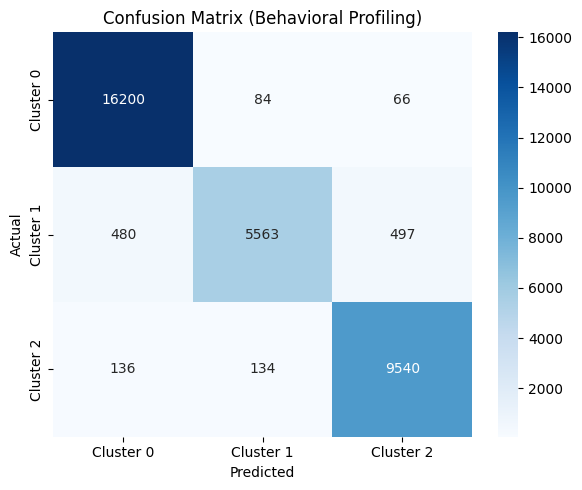

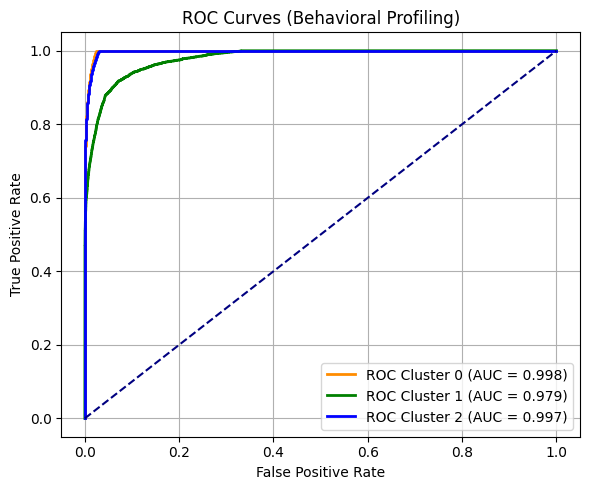

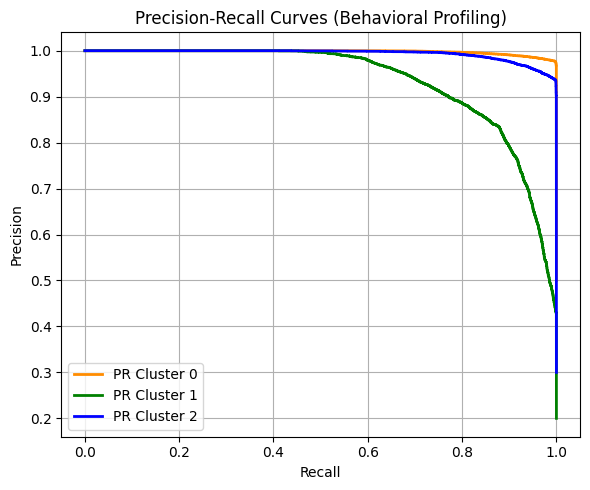


🟩 Model Accuracy: 0.9573

Classification Report (Detailed):

              precision    recall  f1-score   support

   Cluster 0       0.96      0.99      0.98     16350
   Cluster 1       0.96      0.85      0.90      6540
   Cluster 2       0.94      0.97      0.96      9810

    accuracy                           0.96     32700
   macro avg       0.96      0.94      0.95     32700
weighted avg       0.96      0.96      0.96     32700



In [1]:
def evaluate_qnn(X, y, model, pca, n_classes):
    try:
        X_pca = pca.transform(X)
        model.eval()
        with torch.no_grad():
            probs = model(X_pca)
            y_pred = torch.argmax(probs, dim=1).cpu().numpy()
        report = classification_report(y, y_pred, zero_division=0)
        logging.info("Classification Report:\n" + report)
        return y_pred
    except Exception as e:
        logging.error(f"Error in evaluation: {e}")
                raise
        report = classification_report(true_labels, predicted_labels, target_names=target_names)
        print("\nQNN Behavioral Profiling Classification Report:\n")
        print(report)
        
        # Confusion Matrix
        cm = confusion_matrix(true_labels, predicted_labels)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=target_names, yticklabels=target_names)
        plt.title("Confusion Matrix (Behavioral Profiling)")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.savefig('confusion_matrix_behavioral.png')
        plt.show()
        
        # ROC Curve (One-vs-Rest for multi-class)
        y_bin = label_binarize(true_labels, classes=[0, 1, 2])
        plt.figure(figsize=(6, 5))
        colors = ['darkorange', 'green', 'blue']
        for i, color in enumerate(colors):
            fpr, tpr, _ = roc_curve(y_bin[:, i], scores[:, i])
            auc = roc_auc_score(y_bin[:, i], scores[:, i])
            plt.plot(fpr, tpr, color=color, lw=2,
                     label=f'ROC {target_names[i]} (AUC = {auc:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves (Behavioral Profiling)')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('roc_curve_behavioral.png')
        plt.show()
        
        # Precision-Recall Curve (One-vs-Rest for multi-class)
        plt.figure(figsize=(6, 5))
        for i, color in enumerate(colors):
            prec, rec, _ = precision_recall_curve(y_bin[:, i], scores[:, i])
            plt.plot(rec, prec, color=color, lw=2,
                     label=f'PR {target_names[i]}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves (Behavioral Profiling)')
        plt.legend(loc="lower left")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('precision_recall_curve_behavioral.png')
        plt.show()
        
        # Summary Metrics
        accuracy = np.mean(predicted_labels == true_labels)
        print(f"\n🟩 Model Accuracy: {accuracy:.4f}")
        print("\nClassification Report (Detailed):\n")
        print(report)